In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

df1 = pd.read_csv('weibo-search/结果文件/双减政策/双减政策.csv',encoding='utf-8')
df2 = pd.read_csv('weibo-search/结果文件/双减政策/双减政策.csv',encoding='utf-8')
combined_df = pd.concat([df1, df2], ignore_index=True)
df = combined_df.drop_duplicates()

In [2]:
df.columns

Index(['id', 'bid', 'user_id', '用户昵称', '微博正文', '头条文章url', '发布位置', '艾特用户', '话题',
       '转发数', '评论数', '点赞数', '发布时间', '发布工具', '微博图片url', '微博视频url', 'retweet_id',
       'ip', 'user_authentication'],
      dtype='object')

In [3]:
#df.head(1000).to_csv('labled_data.csv')

In [4]:
df.shape

(119704, 19)

In [5]:
df.isna().sum() 

id                          0
bid                         0
user_id                     0
用户昵称                        0
微博正文                       16
头条文章url                118768
发布位置                   113940
艾特用户                   103439
话题                      54695
转发数                         0
评论数                         0
点赞数                         0
发布时间                        0
发布工具                     4066
微博图片url                 66022
微博视频url                104025
retweet_id             112730
ip                     116430
user_authentication      2714
dtype: int64

# 1. 数据预处理

In [4]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import numpy as np
import sklearn
import jieba
import string
from wordcloud import WordCloud
import re 

/Users/huangrui/miniconda3/envs/nlp/lib/python3.12/site-packages/jieba/_compat.py:18: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [ ]:
df_1k=df.iloc[1:1000,]
documents = df_1k["微博正文"]
# 过滤掉非字符串类型的数据
documents = [str(i) for i in documents if isinstance(i, str)]

# 读取停用词文件
with open("stop_words") as f:
    stopwords_chinese = [line.strip() for line in f]
mystopwords = stopwords_chinese + list("0123456789") + list("！，。？")

# 分词
documents1 = [jieba.lcut(i) for i in documents]

# 过滤停用词
documents2 = []
for i in documents1:
    documents2.append([j for j in i if j not in mystopwords])

# 组合成字符串
documents3 = [" ".join(i) for i in documents2]

# 过滤日期字符串
documents3 = [re.sub(r'\d+', "", i) for i in documents3]
documents3 = [re.sub(r'[年月日点时分秒]', "", i) for i in documents3]
documents4=" ".join(documents3)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/_r/j5x7b0zn64q4bj3y_w4fqnv00000gn/T/jieba.cache
Loading model cost 0.238 seconds.
Prefix dict has been built successfully.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wordcloud/wordclou

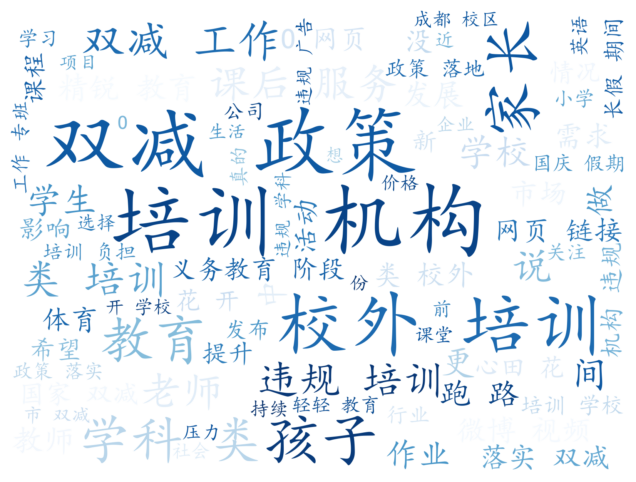

In [8]:
import matplotlib.pyplot as plt
# 创建 WordCloud 对象时设置宽度和高度
wordcloud = WordCloud(
    max_font_size=220,
    max_words=80,
    background_color="white",
    font_path='Kaiti.ttf',
    repeat=False,
    colormap="Blues",
    width=1600,  # 增加宽度
    height=1200  # 增加高度
).generate(documents4)

# 使用 matplotlib 显示并保存词云图，设置 dpi 提高分辨率
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_large_clear.png", dpi=300)  # 设置 dpi 为 300
plt.show()

# 2. 情感分析-ML

## 2.1 导入外部数据集

In [5]:
df_waimai=pd.read_csv(r"/Users/huangrui/Desktop/大四下/7-毕业论文 NLP/data/waimai_10k.csv")

In [6]:
df_weibo=pd.read_csv(r"/Users/huangrui/Desktop/大四下/7-毕业论文 NLP/data/weibo_senti_100k/weibo_senti_100k.csv")

In [7]:
df_weibo.shape

(119988, 2)

In [8]:
from sklearn.model_selection import train_test_split

# 1. 合并两个DataFrame
df_combined = pd.concat([df_weibo, df_waimai], axis=0, ignore_index=True)

# 2. 添加区分来源的列（标记数据来自微博还是外卖）
df_weibo['data_source'] = 'weibo'
df_waimai['data_source'] = 'waimai'
df_combined = pd.concat([df_weibo, df_waimai], axis=0, ignore_index=True)



# 3. 划分训练集和验证集（示例：20%作为验证集）
train_df, val_df = train_test_split(
    df_combined, 
    test_size=0.2,  # 验证集比例
    random_state=42  # 固定随机种子确保可复现
)

train_df.head(5)

,label,review,data_source
117068,0,回复@大卫独夫DE吴志伟:[哈哈][哈哈]内疚的转发[偷笑][偷笑] //@大卫独夫DE吴志...,weibo
108143,0,蚂蚁泛滥，怎么了？？？[抓狂],weibo
63890,0,天气预报bug多到不得了，太带感的温度了，明天就只有七度，看来太阳明天才不会升起来[汗][晕...,weibo
42561,1,@编剧-巩向东 //@作家社-田小爽: 王千源老师可谓是巩老师的知音，据说他扮演的刘向前是最...,weibo
109099,0,额，地铁是个神奇的东东，为毛到了终点不是要全部乘客下车，咋和汽车一样又继续开回去啦[抓狂][...,weibo


## 2.2 朴素贝叶斯

In [ ]:
import pandas as pd
import re
import jieba
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# 读取停用词文件
with open("stop_words") as f:
    stopwords_chinese = [line.strip() for line in f]
mystopwords = stopwords_chinese + list("0123456789") + list("！，。？")

# 文本预处理（分词+去停用词+清洗符号）
def preprocess_text(text):
    # 去除非文字符号
    text_clean = re.sub(r'[^\w\s]', '', text)
    # 中文分词
    seg_words = jieba.lcut(text_clean)
    # 去除停用词
    filtered_words = [word for word in seg_words if word not in mystopwords]
    return ' '.join(filtered_words)

# 处理训练集和验证集
train_df['clean_review'] = train_df['review'].apply(preprocess_text)
val_df['clean_review'] = val_df['review'].apply(preprocess_text)'''


"# 处理训练集和验证集\ntrain_df['clean_review'] = train_df['review'].apply(preprocess_text)\nval_df['clean_review'] = val_df['review'].apply(preprocess_text)"

In [ ]:
train_df.dropna(inplace=True)
val_df.dropna(inplace=True) # 5000条数据

In [12]:
# 特征提取（词频统计）
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['clean_review'])
y_train = train_df['label']

X_val = vectorizer.transform(val_df['clean_review'])
y_val = val_df['label']

# 训练朴素贝叶斯模型
clf = MultinomialNB()
clf.fit(X_train, y_train)

# 验证集评估
y_pred = clf.predict(X_val)
print(f"朴素贝叶斯准确率: {accuracy_score(y_val, y_pred):.4f}")
print("分类报告:\n", classification_report(y_val, y_pred))

朴素贝叶斯准确率: 0.8160
分类报告:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82      2473
           1       0.82      0.81      0.82      2526

    accuracy                           0.82      4999
   macro avg       0.82      0.82      0.82      4999
weighted avg       0.82      0.82      0.82      4999



## 2.3 逻辑回归1：无迁移学习

In [12]:
from sklearn.linear_model import LogisticRegression

# 使用 TF-IDF 方法提取特征
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_review'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['clean_review'])

# 训练逻辑回归模型
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train)

# 验证集评估逻辑回归模型
y_pred_logreg = logreg.predict(X_val_tfidf)
print(f"逻辑回归准确率: {accuracy_score(y_val, y_pred_logreg):.4f}")
print("分类报告:\n", classification_report(y_val, y_pred_logreg))

逻辑回归准确率: 0.8400
分类报告:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      2473
           1       0.87      0.81      0.84      2526

    accuracy                           0.84      4999
   macro avg       0.84      0.84      0.84      4999
weighted avg       0.84      0.84      0.84      4999



## 2.4 逻辑回归2:同一分布

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 读取验证集数据
validation_df = pd.read_csv('val_df.csv')
# 去除数据中的缺失值
validation_df.dropna(inplace=True)

# 提取标签列
labels = validation_df['label']
# 使用 TF-IDF 方法对文本列提取特征
tfidf_vectorizer = TfidfVectorizer()
features = tfidf_vectorizer.fit_transform(validation_df['clean_review'])

# 训练 3 次逻辑回归模型
for iteration in range(3):
    # 将验证集数据按 8 - 2 比例划分为新的训练集和测试集，设置随机种子保证结果可复现
    new_train_features, new_test_features, new_train_labels, new_test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=iteration
    )
    print(f"第 {iteration + 1} 次训练")
    # 创建逻辑回归模型实例
    logistic_regression_model = LogisticRegression()
    # 使用新的训练集训练模型
    logistic_regression_model.fit(new_train_features, new_train_labels)

    # 在新的测试集上进行预测
    predicted_labels = logistic_regression_model.predict(new_test_features)
    # 计算并输出模型在测试集上的准确率
    print(f"逻辑回归准确率: {accuracy_score(new_test_labels, predicted_labels):.4f}")
    # 输出模型在测试集上的分类报告
    print("分类报告:\n", classification_report(new_test_labels, predicted_labels))
    print("-" * 50)
    

第 1 次训练
逻辑回归准确率: 0.8140
分类报告:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82       489
           1       0.85      0.77      0.81       511

    accuracy                           0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000

--------------------------------------------------
第 2 次训练
逻辑回归准确率: 0.8190
分类报告:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82       482
           1       0.88      0.76      0.81       518

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.83      0.82      0.82      1000

--------------------------------------------------
第 3 次训练
逻辑回归准确率: 0.8130
分类报告:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83       517
           1       0.86      0.74      0.7

## 2.5 逻辑回归3:有迁移学习

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import cvxopt.solvers as solvers
import cvxopt

# 定义 KMM 类
class KMM:
    def __init__(self, kernel_type='linear', gamma=1.0, B=1.0, eps=None):
        """
        初始化函数
        :param kernel_type: 'linear' | 'rbf'
        :param gamma: kernel bandwidth for rbf kernel
        :param B: bound for beta
        :param eps: bound for sigma_beta
        """
        self.kernel_type = kernel_type
        self.gamma = gamma
        self.B = B
        self.eps = eps

    def fit(self, Xs, Xt):
        """
        Fit source and target using KMM (compute the coefficients)
        :param Xs: ns * dim
        :param Xt: nt * dim
        :return: Coefficients (Pt / Ps) value vector (Beta in the paper)
        """
        ns = Xs.shape[0]
        nt = Xt.shape[0]
        if self.eps is None:
            self.eps = self.B / np.sqrt(ns)

        def kernel(X1, X2=None, gamma=1.0):
            if X2 is None:
                X2 = X1
            if self.kernel_type == 'linear':
                return np.dot(X1, X2.T)
            elif self.kernel_type == 'rbf':
                n1 = X1.shape[0]
                n2 = X2.shape[0]
                K = np.zeros((n1, n2))
                for i in range(n1):
                    for j in range(n2):
                        diff = X1[i] - X2[j]
                        K[i, j] = np.exp(-gamma * np.dot(diff, diff))
                return K

        K = kernel(Xs, None, self.gamma)
        kappa = np.sum(kernel(Xs, Xt, self.gamma) * float(ns) / float(nt), axis=1)
        K = cvxopt.matrix(K.astype(np.double))
        kappa = cvxopt.matrix(kappa.astype(np.double))
        G = cvxopt.matrix(np.r_[np.ones((1, ns)), -np.ones((1, ns)), np.eye(ns), -np.eye(ns)])
        h = cvxopt.matrix(np.r_[ns * (1 + self.eps), ns * (self.eps - 1), self.B * np.ones((ns,)), np.zeros((ns,))])
        sol = solvers.qp(K, -kappa, G, h)
        beta = np.array(sol['x'])
        return beta

# train_df 和 val_df 数据量很大，先采样
train_df_sample = train_df.sample(n=2000)  # 示例：采样 1000 条数据
val_df_sample = val_df.sample(n=205)  # 示例：采样 500 条数据

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df_sample['clean_review'])
X_val_tfidf = tfidf_vectorizer.transform(val_df_sample['clean_review'])

y_train = train_df_sample['label']
y_val = val_df_sample['label']

kmm = KMM(kernel_type='rbf', B=18)
beta = kmm.fit(X_train_tfidf.toarray(), X_val_tfidf.toarray())  # 小数据量时可尝试 toarray()

logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train, sample_weight=beta.flatten())

y_pred_logreg = logreg.predict(X_val_tfidf)
print(f"逻辑回归准确率: {accuracy_score(y_val, y_pred_logreg):.4f}")
print("分类报告:\n", classification_report(y_val, y_pred_logreg))

     pcost       dcost       gap    pres   dres
 0: -3.0294e+05 -2.9128e+07  3e+07  2e-02  1e-14
 1: -2.6583e+05 -2.1295e+07  2e+07  1e-02  1e-14
 2: -2.6555e+05 -1.8814e+07  2e+07  1e-02  8e-15
 3: -2.6656e+05 -4.0520e+06  4e+06  2e-03  3e-14
 4: -2.9697e+05 -3.9784e+06  4e+06  1e-03  3e-14
 5: -2.9863e+05 -5.8913e+05  3e+05  1e-04  4e-15
 6: -3.0136e+05 -4.2563e+05  1e+05  4e-05  1e-15
 7: -3.0161e+05 -4.2240e+05  1e+05  3e-05  1e-15
 8: -3.0263e+05 -3.4423e+05  4e+04  9e-06  3e-16
 9: -3.0306e+05 -3.2252e+05  2e+04  7e-07  2e-16
10: -3.0330e+05 -3.0629e+05  3e+03  8e-09  2e-16
11: -3.0338e+05 -3.0495e+05  2e+03  4e-09  2e-16
12: -3.0348e+05 -3.0487e+05  1e+03  2e-09  2e-16
13: -3.0346e+05 -3.0438e+05  9e+02  3e-16  4e-16
14: -3.0352e+05 -3.0364e+05  1e+02  6e-16  3e-16
15: -3.0353e+05 -3.0353e+05  5e+00  1e-15  2e-16
16: -3.0353e+05 -3.0353e+05  2e-01  2e-15  2e-16
Optimal solution found.
逻辑回归准确率: 0.8585
分类报告:
               precision    recall  f1-score   support

           0     

'# 假设 train_df 是源域数据，val_df 是目标域数据\n# 使用 TF-IDF 方法提取特征\ntfidf_vectorizer = TfidfVectorizer()\nX_train_tfidf = tfidf_vectorizer.fit_transform(train_df[\'clean_review\'])\nX_val_tfidf = tfidf_vectorizer.transform(val_df[\'clean_review\'])\n\ny_train = train_df[\'label\']\ny_val = val_df[\'label\']\n\n# 使用 KMM 计算源域样本的权重\nkmm = KMM(kernel_type=\'rbf\', B=18)\nbeta = kmm.fit(X_train_tfidf.toarray(), X_val_tfidf.toarray())\n\n# 训练加权逻辑回归模型\nlogreg = LogisticRegression()\nlogreg.fit(X_train_tfidf, y_train, sample_weight=beta.flatten())\n\n# 验证集评估逻辑回归模型\ny_pred_logreg = logreg.predict(X_val_tfidf)\nprint(f"逻辑回归准确率: {accuracy_score(y_val, y_pred_logreg):.4f}")\nprint("分类报告:\n", classification_report(y_val, y_pred_logreg))'

##### 由于0.8585微弱的大于0.8400，因此需要重复实验，我们这里重新反复采样，再测试KMM方法，进行验证

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import cvxopt.solvers as solvers
import cvxopt

# 定义 KMM 类
class KMM:
    def __init__(self, kernel_type='linear', gamma=1.0, B=1.0, eps=None):
        """
        初始化函数
        :param kernel_type: 'linear' | 'rbf'
        :param gamma: kernel bandwidth for rbf kernel
        :param B: bound for beta
        :param eps: bound for sigma_beta
        """
        self.kernel_type = kernel_type
        self.gamma = gamma
        self.B = B
        self.eps = eps

    def fit(self, Xs, Xt):
        """
        Fit source and target using KMM (compute the coefficients)
        :param Xs: ns * dim
        :param Xt: nt * dim
        :return: Coefficients (Pt / Ps) value vector (Beta in the paper)
        """
        ns = Xs.shape[0]
        nt = Xt.shape[0]
        if self.eps is None:
            self.eps = self.B / np.sqrt(ns)

        def kernel(X1, X2=None, gamma=1.0):
            if X2 is None:
                X2 = X1
            if self.kernel_type == 'linear':
                return np.dot(X1, X2.T)
            elif self.kernel_type == 'rbf':
                n1 = X1.shape[0]
                n2 = X2.shape[0]
                K = np.zeros((n1, n2))
                for i in range(n1):
                    for j in range(n2):
                        diff = X1[i] - X2[j]
                        K[i, j] = np.exp(-gamma * np.dot(diff, diff))
                return K

        K = kernel(Xs, None, self.gamma)
        kappa = np.sum(kernel(Xs, Xt, self.gamma) * float(ns) / float(nt), axis=1)
        K = cvxopt.matrix(K.astype(np.double))
        kappa = cvxopt.matrix(kappa.astype(np.double))
        G = cvxopt.matrix(np.r_[np.ones((1, ns)), -np.ones((1, ns)), np.eye(ns), -np.eye(ns)])
        h = cvxopt.matrix(np.r_[ns * (1 + self.eps), ns * (self.eps - 1), self.B * np.ones((ns,)), np.zeros((ns,))])
        sol = solvers.qp(K, -kappa, G, h)
        beta = np.array(sol['x'])
        return beta

In [36]:
# 假设 train_df 和 val_df 数据量很大，先采样
train_df_sample = train_df.sample(n=2000,random_state=1258)  # 示例：采样 1000 条数据
val_df_sample = val_df.sample(n=221,random_state=77)  # 示例：采样 500 条数据

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df_sample['clean_review'])
X_val_tfidf = tfidf_vectorizer.transform(val_df_sample['clean_review'])

y_train = train_df_sample['label']
y_val = val_df_sample['label']

kmm = KMM(kernel_type='rbf', B=18)
beta = kmm.fit(X_train_tfidf.toarray(), X_val_tfidf.toarray())  # 小数据量时可尝试 toarray()

logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train, sample_weight=beta.flatten())

y_pred_logreg = logreg.predict(X_val_tfidf)
print(f"逻辑回归准确率: {accuracy_score(y_val, y_pred_logreg):.4f}")
print("分类报告:\n", classification_report(y_val, y_pred_logreg))

     pcost       dcost       gap    pres   dres
 0: -2.8006e+05 -2.9013e+07  3e+07  1e-15  2e-14
 1: -2.8007e+05 -7.9633e+05  5e+05  1e-15  5e-16
 2: -2.8019e+05 -3.1764e+05  4e+04  2e-15  3e-16
 3: -2.8044e+05 -2.8316e+05  3e+03  2e-15  3e-16
 4: -2.8051e+05 -2.8141e+05  9e+02  1e-15  2e-16
 5: -2.8056e+05 -2.8139e+05  8e+02  2e-15  2e-16
 6: -2.8058e+05 -2.8094e+05  4e+02  2e-15  2e-16
 7: -2.8059e+05 -2.8068e+05  9e+01  2e-15  2e-16
 8: -2.8060e+05 -2.8061e+05  1e+01  2e-15  3e-16
 9: -2.8060e+05 -2.8060e+05  6e-01  4e-16  2e-16
10: -2.8060e+05 -2.8060e+05  2e-02  1e-16  2e-16
Optimal solution found.
逻辑回归准确率: 0.8462
分类报告:
               precision    recall  f1-score   support

           0       0.85      0.80      0.82        98
           1       0.84      0.89      0.87       123

    accuracy                           0.85       221
   macro avg       0.85      0.84      0.84       221
weighted avg       0.85      0.85      0.85       221



In [ ]:
# 假设 train_df 和 val_df 数据量很大，先采样
train_df_sample = train_df.sample(n=2000,random_state=1)  # 示例：采样 1000 条数据
val_df_sample = val_df.sample(n=201,random_state=1)  # 示例：采样 500 条数据

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df_sample['clean_review'])
X_val_tfidf = tfidf_vectorizer.transform(val_df_sample['clean_review'])

y_train = train_df_sample['label']
y_val = val_df_sample['label']

kmm = KMM(kernel_type='rbf', B=18)
beta = kmm.fit(X_train_tfidf.toarray(), X_val_tfidf.toarray())  # 小数据量时可尝试 toarray()

logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train, sample_weight=beta.flatten())

y_pred_logreg = logreg.predict(X_val_tfidf)
print(f"逻辑回归准确率: {accuracy_score(y_val, y_pred_logreg):.4f}")
print("分类报告:\n", classification_report(y_val, y_pred_logreg))

     pcost       dcost       gap    pres   dres
 0: -3.1266e+05 -2.9145e+07  3e+07  1e-15  1e-14
 1: -3.1273e+05 -8.5938e+05  5e+05  8e-16  7e-16
 2: -3.1284e+05 -3.7233e+05  6e+04  2e-15  2e-16
 3: -3.1298e+05 -3.1898e+05  6e+03  7e-17  2e-16
 4: -3.1308e+05 -3.1489e+05  2e+03  1e-15  2e-16
 5: -3.1320e+05 -3.1373e+05  5e+02  1e-15  3e-16
 6: -3.1319e+05 -3.1343e+05  2e+02  2e-15  2e-16
 7: -3.1322e+05 -3.1323e+05  2e+01  9e-16  3e-16
 8: -3.1322e+05 -3.1322e+05  7e-01  2e-15  2e-16
 9: -3.1322e+05 -3.1322e+05  2e-02  2e-15  3e-16
Optimal solution found.
逻辑回归准确率: 0.8458
分类报告:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83        88
           1       0.89      0.82      0.86       113

    accuracy                           0.85       201
   macro avg       0.84      0.85      0.84       201
weighted avg       0.85      0.85      0.85       201



In [25]:
# 假设 train_df 和 val_df 数据量很大，先采样
train_df_sample = train_df.sample(n=2000,random_state=100)  # 示例：采样 1000 条数据
val_df_sample = val_df.sample(n=235,random_state=13)  # 示例：采样 500 条数据

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df_sample['clean_review'])
X_val_tfidf = tfidf_vectorizer.transform(val_df_sample['clean_review'])

y_train = train_df_sample['label']
y_val = val_df_sample['label']

kmm = KMM(kernel_type='rbf', B=18)
beta = kmm.fit(X_train_tfidf.toarray(), X_val_tfidf.toarray())  # 小数据量时可尝试 toarray()

logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train, sample_weight=beta.flatten())

y_pred_logreg = logreg.predict(X_val_tfidf)
print(f"逻辑回归准确率: {accuracy_score(y_val, y_pred_logreg):.4f}")
print("分类报告:\n", classification_report(y_val, y_pred_logreg))

     pcost       dcost       gap    pres   dres
 0: -3.0820e+05 -2.9106e+07  3e+07  2e-02  7e-15
 1: -2.7069e+05 -2.1467e+07  2e+07  1e-02  5e-15
 2: -2.7047e+05 -1.9467e+07  2e+07  1e-02  4e-15
 3: -2.7196e+05 -3.6208e+06  3e+06  2e-03  6e-14
 4: -3.0358e+05 -3.5599e+06  3e+06  9e-04  3e-14
 5: -3.0459e+05 -6.3887e+05  3e+05  1e-04  3e-15
 6: -3.0248e+05 -5.6866e+05  3e+05  1e-05  4e-16
 7: -3.0677e+05 -4.1317e+05  1e+05  9e-16  3e-16
 8: -3.0788e+05 -3.4102e+05  3e+04  4e-15  3e-16
 9: -3.0832e+05 -3.1888e+05  1e+04  3e-15  2e-16
10: -3.0850e+05 -3.1032e+05  2e+03  7e-16  2e-16
11: -3.0864e+05 -3.1051e+05  2e+03  9e-16  2e-16
12: -3.0867e+05 -3.0970e+05  1e+03  1e-15  2e-16
13: -3.0870e+05 -3.0881e+05  1e+02  2e-16  2e-16
14: -3.0872e+05 -3.0873e+05  1e+01  1e-15  2e-16
15: -3.0872e+05 -3.0872e+05  6e-01  2e-15  2e-16
16: -3.0872e+05 -3.0872e+05  5e-02  5e-16  2e-16
Optimal solution found.
逻辑回归准确率: 0.8468
分类报告:
               precision    recall  f1-score   support

           0     

## 2.6 卷积神经网络

In [8]:
# 神经网络
import pandas as pd
import re
import jieba
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense


# 2. 构建词汇表
max_features = 10000  # 保留的最大词数
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_df['clean_review'])

# 3. 文本转序列
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_review'])
X_val_seq = tokenizer.texts_to_sequences(val_df['clean_review'])

# 4. 序列填充
max_length = 100  # 文本最大长度
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length)

# 5. 准备标签
y_train = train_df['label'].values
y_val = val_df['label'].values


In [9]:
# 6. 构建TextCNN模型
model = Sequential([
    Embedding(input_dim=max_features, output_dim=128, input_length=max_length),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 二分类问题
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 7. 训练模型
model.fit(X_train_pad, y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_val_pad, y_val))

# 8. 评估验证集
loss, accuracy = model.evaluate(X_val_pad, y_val)
print(f"验证集准确率: {accuracy:.4f}")

Epoch 1/10
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9066 - loss: 0.2228 - val_accuracy: 0.9466 - val_loss: 0.1504
Epoch 2/10
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9496 - loss: 0.1336 - val_accuracy: 0.9416 - val_loss: 0.1566
Epoch 3/10
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9666 - loss: 0.0896 - val_accuracy: 0.9360 - val_loss: 0.2016
Epoch 4/10
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9773 - loss: 0.0549 - val_accuracy: 0.9364 - val_loss: 0.2751
Epoch 5/10
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9811 - loss: 0.0400 - val_accuracy: 0.9334 - val_loss: 0.3196
Epoch 6/10
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9831 - loss: 0.0328 - val_accuracy: 0.9140 - val_loss: 0.3940
Epoch 7/10
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.9835 - loss: 0.0319 - val_accuracy: 0.9352 - val_loss: 0.4368
Epoch 8/10
2999/2999 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.9842 - loss: 0

In [10]:
# 添加分类报告部分
from sklearn.metrics import classification_report

# 预测验证集类别（二分类，阈值0.5）
y_pred_probs = model.predict(X_val_pad)  # 获取预测概率
y_pred_class = (y_pred_probs > 0.5).astype(int)  # 转换为类别标签

# 生成分类报告
class_report = classification_report(y_val, y_pred_class)
print("分类报告：")
print(class_report)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
分类报告：
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2473
           1       0.92      0.94      0.93      2526

    accuracy                           0.93      4999
   macro avg       0.93      0.93      0.93      4999
weighted avg       0.93      0.93      0.93      4999



In [ ]:
model.save("my_cnn_model.h5")

In [23]:
# 加载模型 重新做预测
from tensorflow.keras.models import load_model

loaded_model_cnn = load_model("my_cnn_model.h5")

# 现在你可以使用loaded_model进行预测等操作
y_pred_probs_cn = loaded_model_cnn.predict(X_val_pad)  # 获取预测概率
y_pred_class_cn = (y_pred_probs_cn > 0.5).astype(int)  # 转换为类别标签

# 生成分类报告
class_report_cn = classification_report(y_val, y_pred_class_cn)
print("分类报告：")
print(class_report_cn)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
分类报告：
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2473
           1       0.92      0.94      0.93      2526

    accuracy                           0.93      4999
   macro avg       0.93      0.93      0.93      4999
weighted avg       0.93      0.93      0.93      4999



## 2.7 循环神经网络

In [15]:
from tensorflow.keras.layers import SimpleRNN  # 导入循环神经网络层

# 6. 构建RNN模型
rnn_model = Sequential([
    Embedding(input_dim=max_features, output_dim=300, input_length=max_length),
    SimpleRNN(64, activation='relu'),  # 添加循环神经网络层
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 二分类输出
])

rnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# 7. 训练RNN模型
rnn_model.fit(X_train_pad, y_train,
              epochs=10,
              batch_size=64,
              validation_data=(X_val_pad, y_val))

# 8. 评估验证集
loss, accuracy = rnn_model.evaluate(X_val_pad, y_val)
print(f"RNN模型验证集准确率: {accuracy:.4f}")

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.8927 - loss: 0.2652 - val_accuracy: 0.9464 - val_loss: 0.1583
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.9501 - loss: 0.1390 - val_accuracy: 0.9432 - val_loss: 0.1645
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.9638 - loss: 0.0982 - val_accuracy: 0.9360 - val_loss: 0.1984
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.9735 - loss: 0.0661 - val_accuracy: 0.9338 - val_loss: 0.2464
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.9773 - loss: 0.0555 - val_accuracy: 0.9300 - val_loss: 0.2760
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - accuracy: 0.9795 - loss: 0.0450 - val_accuracy: 0.9162 - val_loss: 0.2947
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.9818 - loss: 0.0392 - val_accuracy: 0.9216 - val_loss: 0.3535
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - accuracy: 0.9805 -

In [16]:
# 添加分类报告部分
from sklearn.metrics import classification_report

# 预测验证集类别（二分类，阈值0.5）
y_pred_probs_RNN = rnn_model.predict(X_val_pad)  # 获取预测概率
y_pred_class_RNN = (y_pred_probs_RNN > 0.5).astype(int)  # 转换为类别标签

# 生成分类报告
class_report_RNN = classification_report(y_val, y_pred_class_RNN)
print("分类报告：")
print(class_report_RNN)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
分类报告：
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2473
           1       0.92      0.92      0.92      2526

    accuracy                           0.92      4999
   macro avg       0.92      0.92      0.92      4999
weighted avg       0.92      0.92      0.92      4999



In [ ]:
rnn_model.save("my_rnn_model.h5")

In [22]:
# 加载模型 重新做预测
from tensorflow.keras.models import load_model

loaded_model_rnn = load_model("my_rnn_model.h5")

# 现在你可以使用loaded_model进行预测等操作
y_pred_probs_rn = loaded_model_rnn.predict(X_val_pad)  # 获取预测概率
y_pred_class_rn = (y_pred_probs_rn > 0.5).astype(int)  # 转换为类别标签

# 生成分类报告
class_report_rn = classification_report(y_val, y_pred_class_rn)
print("分类报告：")
print(class_report_rn)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
分类报告：
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2473
           1       0.92      0.92      0.92      2526

    accuracy                           0.92      4999
   macro avg       0.92      0.92      0.92      4999
weighted avg       0.92      0.92      0.92      4999



## 2.8 LSTM网络

In [11]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# 假设已有处理好的 X_train_pad（长度200）、X_val_pad、y_train、y_val
max_length = 200  # 匹配Sequence_length参数

# 构建单层Bi-LSTM模型
bi_lstm_model = Sequential([
    # Embedding层
    Embedding(input_dim=max_features, output_dim=300, input_length=max_length),
    # 单层Bi-LSTM，双向，带偏置，不返回序列
    Bidirectional(LSTM(units=64, return_sequences=False, use_bias=True)),
    Dropout(0.5),  # 应用漏失率
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 二分类输出
])

# 编译模型，使用Adam优化器，学习率0.002
optimizer = Adam(learning_rate=0.002)
bi_lstm_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 训练模型，匹配Batch_size=128，Num_epochs=10
bi_lstm_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val_pad, y_val)
)

# 评估验证集
loss, accuracy = bi_lstm_model.evaluate(X_val_pad, y_val)
print(f"Bi-LSTM模型验证集准确率: {accuracy:.4f}")

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 103s 136ms/step - accuracy: 0.9015 - loss: 0.2480 - val_accuracy: 0.9442 - val_loss: 0.1545
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 109s 145ms/step - accuracy: 0.9461 - loss: 0.1441 - val_accuracy: 0.9456 - val_loss: 0.1554
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 112s 150ms/step - accuracy: 0.9589 - loss: 0.1108 - val_accuracy: 0.9428 - val_loss: 0.1708
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 111s 148ms/step - accuracy: 0.9641 - loss: 0.0880 - val_accuracy: 0.9388 - val_loss: 0.2029
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 113s 151ms/step - accuracy: 0.9673 - loss: 0.0788 - val_accuracy: 0.9378 - val_loss: 0.2250
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 114s 152ms/step - accuracy: 0.9738 - loss: 0.0591 - val_accuracy: 0.9338 - val_loss: 0.2698
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 110s 147ms/step - accuracy: 0.9756 - loss: 0.0534 - val_accuracy: 0.9314 - val_loss: 0.3356
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 111s 148ms/step - accuracy: 0.9777 -

In [12]:
# 添加分类报告部分
from sklearn.metrics import classification_report

# 预测验证集类别（二分类，阈值0.5）
y_pred_probs_LSTM = bi_lstm_model.predict(X_val_pad)  # 获取预测概率
y_pred_class_LSTM = (y_pred_probs_LSTM > 0.5).astype(int)  # 转换为类别标签

# 生成分类报告
class_report_LSTM = classification_report(y_val, y_pred_class_LSTM)
print("分类报告：")
print(class_report_LSTM)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
分类报告：
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2473
           1       0.93      0.93      0.93      2526

    accuracy                           0.93      4999
   macro avg       0.93      0.93      0.93      4999
weighted avg       0.93      0.93      0.93      4999



In [ ]:
bi_lstm_model.save("my_lstm_model.h5")

In [21]:
# 加载模型 重新做预测
from tensorflow.keras.models import load_model

loaded_model_lstm = load_model("my_lstm_model.h5")

# 现在你可以使用loaded_model进行预测等操作
y_pred_probs_LS = loaded_model_lstm.predict(X_val_pad)  # 获取预测概率
y_pred_class_LS = (y_pred_probs_LSTM > 0.5).astype(int)  # 转换为类别标签

# 生成分类报告
class_report_LS = classification_report(y_val, y_pred_class_LS)
print("分类报告：")
print(class_report_LS)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
分类报告：
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2473
           1       0.93      0.93      0.93      2526

    accuracy                           0.93      4999
   macro avg       0.93      0.93      0.93      4999
weighted avg       0.93      0.93      0.93      4999



## 2.9 使用ML对双减数据集分类

In [45]:
df = combined_df.drop_duplicates()
df['发布时间']

0         2021-10-11 02:19
1         2021-10-11 01:54
2         2021-10-11 01:42
3         2021-10-11 01:41
4         2021-10-11 01:29
                ...       
120125    2021-10-11 20:51
120126    2021-10-11 21:46
120127    2021-10-11 19:58
120128    2021-10-11 10:06
120129    2021-10-11 21:45
Name: 发布时间, Length: 119704, dtype: object

In [46]:
df.columns

Index(['id', 'bid', 'user_id', '用户昵称', '微博正文', '头条文章url', '发布位置', '艾特用户', '话题',
       '转发数', '评论数', '点赞数', '发布时间', '发布工具', '微博图片url', '微博视频url', 'retweet_id',
       'ip', 'user_authentication'],
      dtype='object')

In [ ]:
import pandas as pd
import re
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# 预处理函数
def preprocess_text(text):
    text_clean = re.sub(r'[^\w\s]', '', str(text))
    seg_words = jieba.lcut(text_clean)
    mystopwords = list("0123456789") + list("！，。？")
    filtered_words = [word for word in seg_words if word not in mystopwords]
    return ' '.join(filtered_words)

# 1. 对df的微博正文预处理
df['processed_text'] = df['微博正文'].apply(preprocess_text)

"# 1. 对df的微博正文预处理\ndf['processed_text'] = df['微博正文'].apply(preprocess_text)"

In [51]:
df=df.dropna(subset=['processed_text'])

In [52]:
# 特征转换
X_df = vectorizer.transform(df['processed_text'])

# 2. 用朴素贝叶斯模型预测标签
df['pred_label'] = clf.predict(X_df)

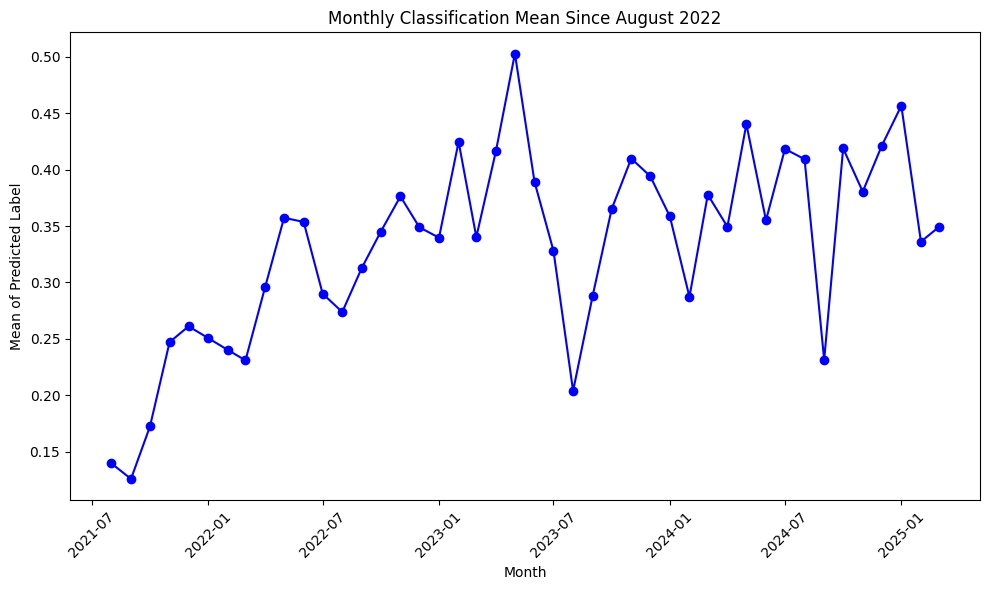

In [ ]:
# 3. 处理发布时间，按月分组
df['发布时间'] = pd.to_datetime(df['发布时间'])
df['month'] = df['发布时间'].dt.strftime('%Y-%m')

# 4. 按月计算0-1分类的均值
monthly_mean = df.groupby('month')['pred_label'].mean().reset_index()

import pandas as pd
import matplotlib.pyplot as plt

# 筛选2022年8月及以后的数据
monthly_mean['month'] = pd.to_datetime(monthly_mean['month'])
monthly_mean = monthly_mean[monthly_mean['month'] >= '2021-08-01']

# 按时间排序
monthly_mean = monthly_mean.sort_values('month')

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(monthly_mean['month'], monthly_mean['pred_label'], 
         marker='o', linestyle='-', color='blue')

# 添加标题和坐标轴标签
plt.title('Monthly Classification Mean Since August 2022')
plt.xlabel('Month')
plt.ylabel('Mean of Predicted Label')

# 调整x轴标签显示角度
plt.xticks(rotation=45)

# 显示图形
plt.tight_layout()
plt.show()


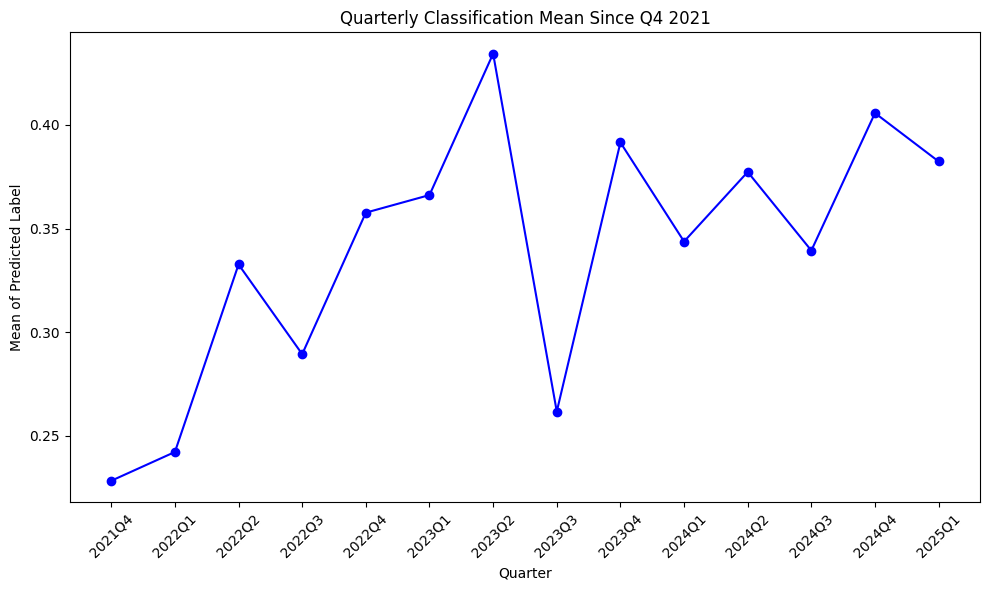

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# 3. 处理发布时间，按季度分组
df['发布时间'] = pd.to_datetime(df['发布时间'])
df['quarter'] = df['发布时间'].dt.to_period('Q')

# 4. 按季度计算 0 - 1 分类的均值
quarterly_mean = df.groupby('quarter')['pred_label'].mean().reset_index()

# 筛选 2021 年 Q4 及以后的数据
quarterly_mean['quarter'] = quarterly_mean['quarter'].astype(str)
quarterly_mean = quarterly_mean[quarterly_mean['quarter'] >= '2021Q4']

# 按时间排序
quarterly_mean = quarterly_mean.sort_values('quarter')

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(quarterly_mean['quarter'], quarterly_mean['pred_label'], 
         marker='o', linestyle='-', color='blue')

# 添加标题和坐标轴标签
plt.title('Quarterly Classification Mean Since Q4 2021')
plt.xlabel('Quarter')
plt.ylabel('Mean of Predicted Label')

# 调整 x 轴标签显示角度
plt.xticks(rotation=45)

# 显示图形
plt.tight_layout()
plt.show()
    

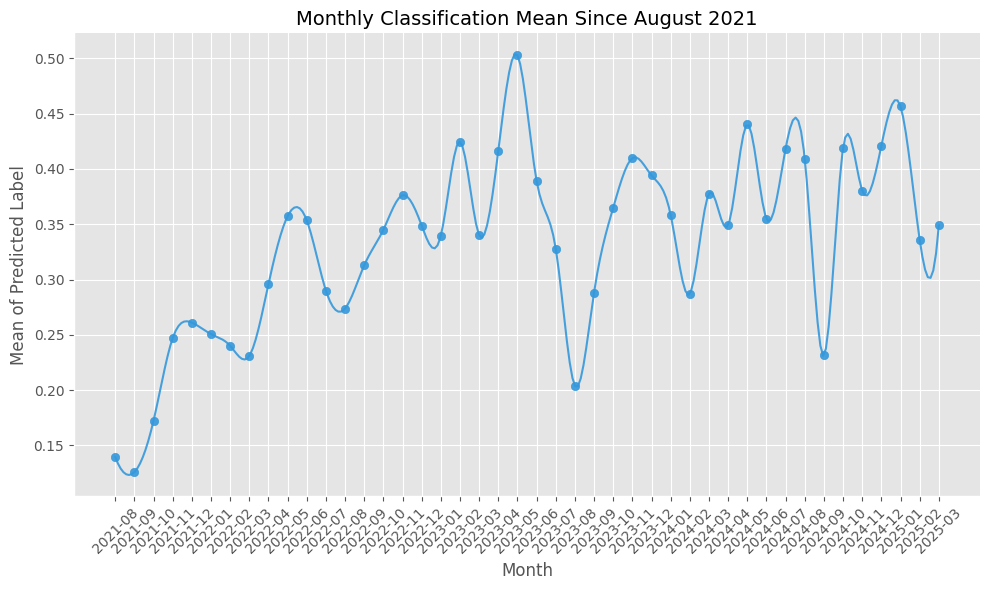

In [78]:
# 特征转换
X_df_LR = vectorizer.transform(df['processed_text'])

# 用逻辑回归预测标签
df['pred_label_LR'] = clf.predict(X_df_LR)

# 3. 处理发布时间，按月分组
df['发布时间'] = pd.to_datetime(df['发布时间'])
df['month'] = df['发布时间'].dt.strftime('%Y-%m')

# 4. 按月计算0-1分类的均值
monthly_mean = df.groupby('month')['pred_label_LR'].mean().reset_index()

import pandas as pd
import matplotlib.pyplot as plt

# 筛选2022年8月及以后的数据
monthly_mean['month'] = pd.to_datetime(monthly_mean['month'])
monthly_mean = monthly_mean[monthly_mean['month'] >= '2021-08-01']

# 按时间排序
monthly_mean = monthly_mean.sort_values('month')

from scipy.interpolate import interp1d
# 生成平滑曲线数据
x = np.arange(len(monthly_mean))  # 生成索引作为x轴数值
f = interp1d(x, monthly_mean['pred_label_LR'], kind='cubic')  # 三次样条插值
xnew = np.linspace(0, x.max(), 300)  # 生成更密集的x值
ynew = f(xnew)  # 计算对应的y值

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(xnew, ynew, linestyle='-', color='#3498db', alpha=0.9)  # 绘制平滑曲线
plt.scatter(x, monthly_mean['pred_label_LR'], marker='o', color='#3498db', alpha=0.9)  # 绘制原始数据点

# 添加标题和坐标轴标签
plt.title('Monthly Classification Mean Since August 2021', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Mean of Predicted Label', fontsize=12)

# 调整x轴标签为实际月份并旋转
plt.xticks(x, monthly_mean['month'].dt.strftime('%Y-%m'), rotation=45)

# 去掉顶部和右侧边框，使图表更简洁
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

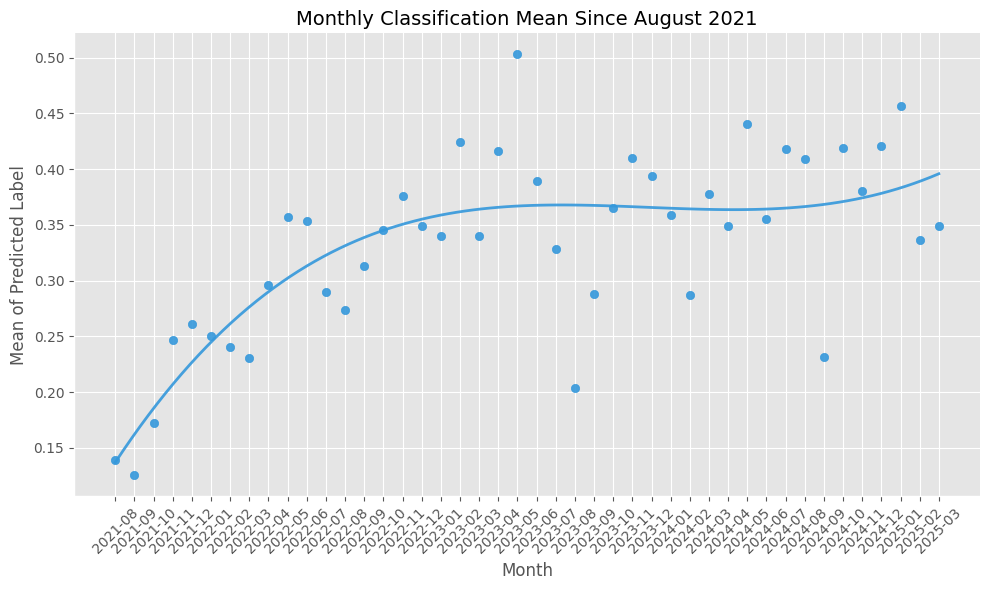

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 假设monthly_mean已处理好（筛选、排序等步骤不变）
monthly_mean['month'] = pd.to_datetime(monthly_mean['month'])
monthly_mean = monthly_mean[monthly_mean['month'] >= '2021-08-01']
monthly_mean = monthly_mean.sort_values('month')

x = np.arange(len(monthly_mean))  # 转换为数值索引
y = monthly_mean['pred_label_LR'].values

# 多项式拟合（以3阶为例，可根据效果调整阶数）
z = np.polyfit(x, y, 3)
p = np.poly1d(z)  # 生成拟合多项式

xnew = np.linspace(0, x.max(), 100)  # 生成拟合曲线的x值
ynew = p(xnew)  # 计算拟合曲线的y值

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(xnew, ynew, color='#3498db', alpha=0.9, linewidth=2)  # 绘制拟合曲线
plt.scatter(x, y, marker='o', color='#3498db', alpha=0.9)  # 绘制原始数据点

# 添加标题和坐标轴标签
plt.title('Monthly Classification Mean Since August 2021', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Mean of Predicted Label', fontsize=12)

# 调整x轴标签为实际月份并旋转
plt.xticks(x, monthly_mean['month'].dt.strftime('%Y-%m'), rotation=45)

# 去掉顶部和右侧边框
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

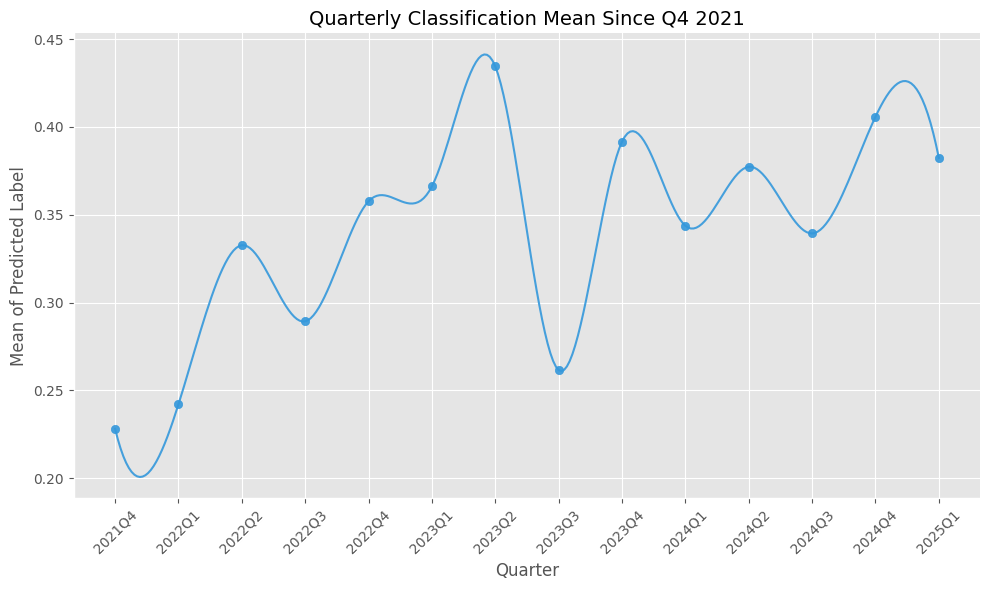

In [77]:
from scipy.interpolate import interp1d
# 3. 处理发布时间，按季度分组
df['发布时间'] = pd.to_datetime(df['发布时间'])
df['quarter'] = df['发布时间'].dt.to_period('Q')

# 4. 按季度计算 0 - 1 分类的均值
quarterly_mean = df.groupby('quarter')['pred_label_LR'].mean().reset_index()

# 筛选 2021 年 Q4 及以后的数据
quarterly_mean['quarter'] = quarterly_mean['quarter'].astype(str)
quarterly_mean = quarterly_mean[quarterly_mean['quarter'] >= '2021Q4']

# 按时间排序
quarterly_mean = quarterly_mean.sort_values('quarter')

# 生成平滑曲线
x = np.arange(len(quarterly_mean['quarter']))
f = interp1d(x, quarterly_mean['pred_label_LR'], kind='cubic')
xnew = np.linspace(x.min(), x.max(), 300)
ynew = f(xnew)

# 绘制折线图
plt.figure(figsize=(10, 6))

# 调整颜色为更鲜艳的蓝色，并适当提高透明度（或去掉透明度）
plt.plot(xnew, ynew, 
         linestyle='-', color='#3498db', alpha=0.9)  # 采用较深的蓝色，如#3498db，alpha调至0.9
plt.scatter(x, quarterly_mean['pred_label_LR'], 
            marker='o', color='#3498db', alpha=0.9)  # 数据点颜色同步调整

# 添加标题和坐标轴标签，增大字体
plt.title('Quarterly Classification Mean Since Q4 2021', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Mean of Predicted Label', fontsize=12)

# 设置x轴刻度标签
plt.xticks(x, quarterly_mean['quarter'], rotation=45)

# 去掉顶部和右侧边框，使图表更简洁
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 调整布局并显示
plt.tight_layout()
plt.show()

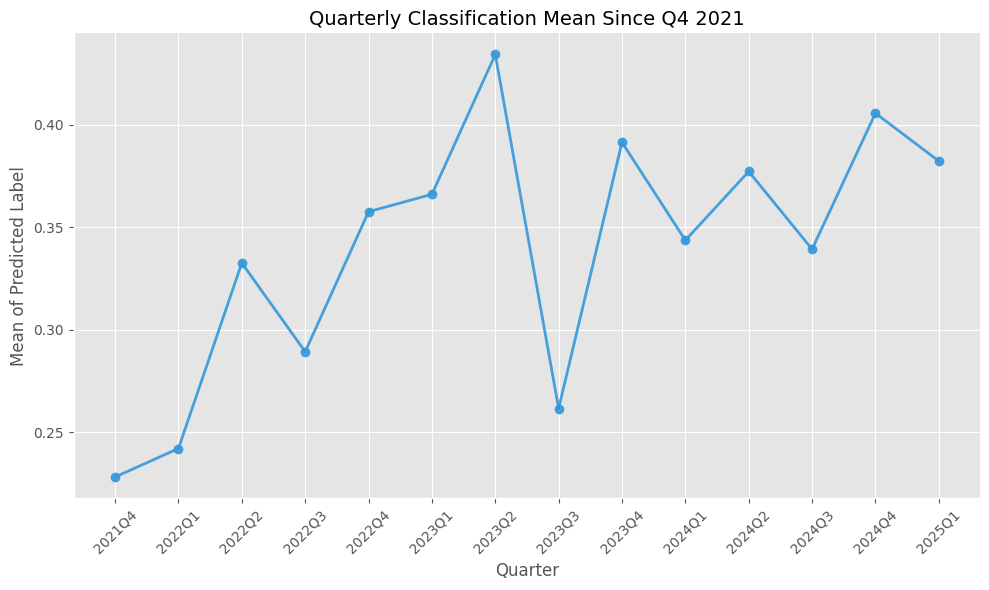

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df 数据已经定义好

# 3. 处理发布时间，按季度分组
df['发布时间'] = pd.to_datetime(df['发布时间'])
df['quarter'] = df['发布时间'].dt.to_period('Q')

# 4. 按季度计算 0 - 1 分类的均值
quarterly_mean = df.groupby('quarter')['pred_label_LR'].mean().reset_index()

# 筛选 2021 年 Q4 及以后的数据
quarterly_mean['quarter'] = quarterly_mean['quarter'].astype(str)
quarterly_mean = quarterly_mean[quarterly_mean['quarter'] >= '2021Q4']

# 按时间排序
quarterly_mean = quarterly_mean.sort_values('quarter')

# 绘制图形
plt.figure(figsize=(10, 6))
# 使用更鲜艳的颜色和合适的透明度
plt.plot(quarterly_mean['quarter'], quarterly_mean['pred_label_LR'],
         marker='o', linestyle='-', color='#3498db', alpha=0.9, linewidth=2)

# 添加标题和坐标轴标签，增大字体
plt.title('Quarterly Classification Mean Since Q4 2021', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Mean of Predicted Label', fontsize=12)

# 调整 x 轴标签显示角度
plt.xticks(rotation=45)

# 去掉顶部和右侧边框，使图表更简洁
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## 2.10 使用DL对双减数据集分类

3741/3741 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


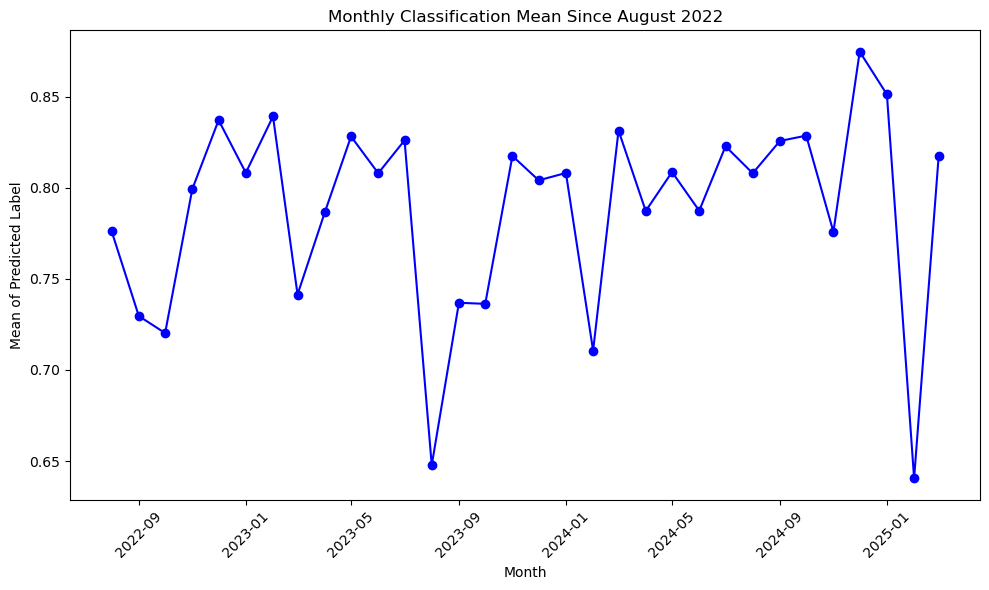

In [42]:
# 接着之前的神经网络1的第1-7步
import pandas as pd
import matplotlib.pyplot as plt
# 8. 使用训练好的模型进行预测
X_df_seq = tokenizer.texts_to_sequences(df['processed_text'])
X_df_pad = pad_sequences(X_df_seq, maxlen=max_length)
df['pred_label'] = (model.predict(X_df_pad) > 0.5).astype(int)

# 9. 处理发布时间，按月分组
df['发布时间'] = pd.to_datetime(df['发布时间'])
df['month'] = df['发布时间'].dt.strftime('%Y-%m')

# 10. 按月计算0 - 1分类的均值
monthly_mean = df.groupby('month')['pred_label'].mean().reset_index()

# 11. 筛选2022年8月及以后的数据
monthly_mean['month'] = pd.to_datetime(monthly_mean['month'])
monthly_mean = monthly_mean[monthly_mean['month'] >= '2022-08-01']

# 12. 按时间排序
monthly_mean = monthly_mean.sort_values('month')

# 13. 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(monthly_mean['month'], monthly_mean['pred_label'],
         marker='o', linestyle='-', color='blue')

# 14. 添加标题和坐标轴标签
plt.title('Monthly Classification Mean Since August 2022')
plt.xlabel('Month')
plt.ylabel('Mean of Predicted Label')

# 15. 调整x轴标签显示角度
plt.xticks(rotation=45)

# 16. 显示图形
plt.tight_layout()
plt.show()
    

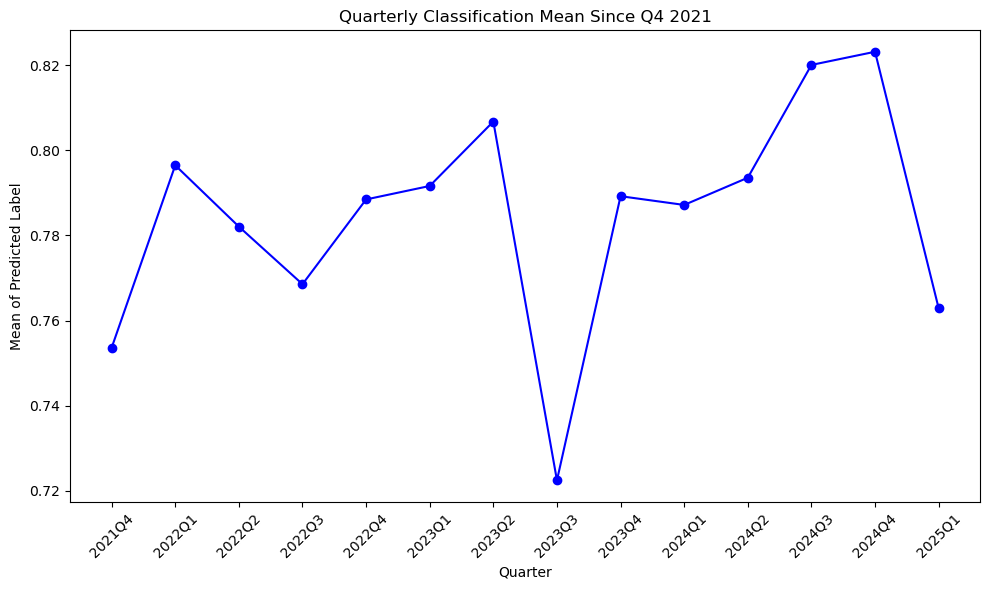

In [43]:
# 9. 处理发布时间，按季度分组
df['发布时间'] = pd.to_datetime(df['发布时间'])
df['quarter'] = df['发布时间'].dt.to_period('Q')

# 10. 按季度计算 0 - 1 分类的均值
quarterly_mean = df.groupby('quarter')['pred_label'].mean().reset_index()

# 11. 筛选 2021 年 Q4 及以后的数据
quarterly_mean['quarter'] = quarterly_mean['quarter'].astype(str)
quarterly_mean = quarterly_mean[quarterly_mean['quarter'] >= '2021Q4']

# 12. 按时间排序
quarterly_mean = quarterly_mean.sort_values('quarter')

# 13. 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(quarterly_mean['quarter'], quarterly_mean['pred_label'],
         marker='o', linestyle='-', color='blue')

# 14. 添加标题和坐标轴标签
plt.title('Quarterly Classification Mean Since Q4 2021')
plt.xlabel('Quarter')
plt.ylabel('Mean of Predicted Label')

# 15. 调整 x 轴标签显示角度
plt.xticks(rotation=45)

# 16. 显示图形
plt.tight_layout()
plt.show()
    

# 3. 主题挖掘

## 3.1 LDA主题分类

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import sklearn

import jieba
import pandas as pd
import warnings

/Users/huangrui/miniconda3/envs/nlp/lib/python3.12/site-packages/jieba/_compat.py:18: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [11]:
df=df.dropna(subset=['微博正文'])

documents = df["微博正文"]

documents1=[jieba.lcut(i) for i in documents]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.330 seconds.
Prefix dict has been built successfully.


In [12]:
documents2=list()
for i in documents1:
    documents2.append([j for j in i if j not in mystopwords])
documents3=[" ".join(i) for i in documents2]
import re # 过滤日期字符串
documents3= [re.sub(r'\d+', "", i) for i in documents3] 
documents3= [re.sub(r'[年月日点时分秒]', "", i) for i in documents3]

In [13]:
#tf-idf算法
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                   stop_words = mystopwords,
                                   lowercase = True,
                                   max_df = 0.4, 
                                   min_df = 8)
dtm_tfidf = tfidf_vectorizer.fit_transform(documents3)
print(dtm_tfidf.shape)

(119688, 53744)


In [16]:
import pickle
with open('documents1.pkl', 'wb') as f:
    pickle.dump(documents1, f)
with open('documents2.pkl', 'wb') as f:
    pickle.dump(documents2, f)
with open('documents3.pkl', 'wb') as f:
    pickle.dump(documents3, f)

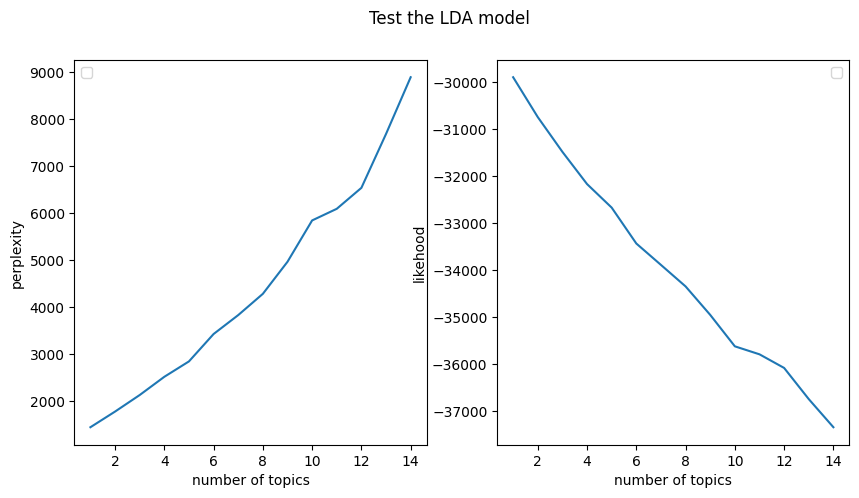

In [ ]:
#对LDA模型的主题数目进行初步探索，我认为可以确定比较好的主题数是7
plexs=[] #困惑度
scores=[] #一致度
n_max_topics = 16
for i in range(1, n_max_topics):
    lda = LatentDirichletAllocation(n_components=i,max_iter=40,learning_offset=50,random_state=0)
    lda.fit(dtm_tfidf)
    plexs.append(lda.perplexity(dtm_tfidf))
    scores.append(lda.score(dtm_tfidf))
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

n_t=15
x = list(range(1,n_t))

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2, figure=fig)
plt.suptitle("Test the LDA model")

ax1 = fig.add_subplot(gs[0])
ax1.plot(x,plexs[1:n_t])
ax1.set_xlabel("number of topics")
ax1.set_ylabel("perplexity")
ax1.legend()

ax2 = fig.add_subplot(gs[1])
ax2.plot(x,scores[1:n_t])
ax2.set_xlabel("number of topics")
ax2.set_ylabel("likehood")
ax2.legend()

plt.show()

In [14]:
#将这些数据套入lda模型，设置主题数为7
lda=LatentDirichletAllocation(n_components=7,max_iter=40,learning_offset=50,random_state=0)
lda.fit(dtm_tfidf)
vis = pyLDAvis.lda_model.prepare(lda, dtm_tfidf, tfidf_vectorizer)
pyLDAvis.display(vis)

In [17]:
lda5=LatentDirichletAllocation(n_components=5,max_iter=40,learning_offset=50,random_state=0)
lda5.fit(dtm_tfidf)

LatentDirichletAllocation(learning_offset=50, max_iter=40, n_components=5,
                          random_state=0)

In [18]:
with open('lda5.pkl', 'wb') as f :
    pickle.dump(lda5,f)

In [ ]:
#因为lda模型每次模拟出来的结果似乎是不一样的，因此我将这些数据保存了一下
import pickle

with open('tfidf_vectorizer.pkl', 'wb') as f :
    pickle.dump(tfidf_vectorizer,f)
with open('dtm_tfidf.pkl', 'wb') as f :
    pickle.dump(dtm_tfidf,f)
with open('lda7.pkl', 'wb') as f :
    pickle.dump(lda,f)
#也就是上述lda模型的结果 在这里可以导入
with open('tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
with open('dtm_tfidf.pkl', 'rb') as f :
    dtm_tfidf = pickle.load(f)
with open('lda7.pkl', 'rb') as f :
    lda = pickle.load(f)

In [5]:
import pickle
with open('lda5.pkl', 'rb') as f :
    lda5 = pickle.load(f)
with open('tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
with open('dtm_tfidf.pkl', 'rb') as f :
    dtm_tfidf = pickle.load(f)

In [29]:
with open('lda5.pkl', 'rb') as f :
    lda5 = pickle.load(f)
vis5 = pyLDAvis.lda_model.prepare(lda5, dtm_tfidf, tfidf_vectorizer)
pyLDAvis.display(vis5)

In [7]:
n_top_words=30
tf_feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names=tf_feature_names
for topic_idx, topic in enumerate(lda5.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    print("index",topic_idx+1,"的关键词为: "," ".join(top_features),sep="")

index1的关键词为: 孩子 家长 老师 教育 真的 机构 教培 焦虑 学校 国家 培训 学生 退费 作业 行业 学习 新东方 补课 英语 视频 教师 微博 希望 父母 考试 影响 压力 感觉 高考 落地
index2的关键词为: 培训 机构 校外 学科 同步 超话 华腾 链接 课堂 学习 违规 教育 网页 免费 内容 体验 教育部 打卡 寒假 义务教育 工作 阶段 学生 视频 教育局 收费 发布 监管 微信 落实
index3的关键词为: app 新学期 备案 一图 下线 作业 搜题 拍照 教育部 教育 通知 开学 审核 教资 倒计 你划 撤销 晚自习 周知 视频 中小学生 学生 培训 微博 多地 行政部门 实施 恢复 变化 相关
index4的关键词为: 学生 教育 学校 课后 服务 活动 小学 孩子 作业 落实 教师 工作 发展 学习 家长 教学 视频 校园 老师 微博 实践 提升 落地 课程 课堂 家庭教育 体育 生活 成长 链接
index5的关键词为: 发展 市场 企业 绿色 经济 公司 中国 建设 行业 亿元 消费 增长 科技 产业 推动 持续 项目 推进 研究 教育 需求 影响 投资 支持 转型 生态 创新 能源 板块 加快


## 3.2 主题河流图

In [8]:
df=df.dropna(subset=['微博正文'])
df[1:10]

,id,bid,user_id,用户昵称,微博正文,头条文章url,发布位置,艾特用户,话题,转发数,评论数,点赞数,发布时间,发布工具,微博图片url,微博视频url,retweet_id,ip,user_authentication
1,4690930575343642,KC9wdmq7M,1299204425,学法律的语文老师,输不起的性格and只好说满意@QQ浏览器O输不起的性格and只好说满意也不知道是哪个倒霉孩子...,NaN,厦门,QQ浏览器,"相亲,微信,律师,自考,双减政策",3,0,1,2021-10-11 01:54,OPPO A93 5G,https://wx1.sinaimg.cn/large/001pVkq5gy1gvaqz1...,NaN,NaN,NaN,黄V
2,4690927694119556,KC9rzhhGs,5579590311,这个汤圆大又圆,#双减政策#当教培遇到双减待业两个多月至今仍在刷简历找工作面试到心态炸裂英语专业等待被捞上岸...,NaN,NaN,NaN,双减政策,0,34,10,2021-10-11 01:42,HUAWEI Mate30 Pro 5G,NaN,NaN,NaN,NaN,普通用户
3,4690927249785346,KC9qQF3Ca,7531033297,哈-哈-哈H,刚查完分。自分班以来每次大考都稳在班级1112但红榜只截至每班前十我一向少于成绩排名同哀乐只...,NaN,NaN,NaN,NaN,0,0,0,2021-10-11 01:41,Android,NaN,NaN,NaN,NaN,普通用户
4,4690924367512463,KC9mcvwkL,6389547884,网信宝坻,【有机构假借托管隐身楼宇开展培训！长假期间，天津开展“双减”督察】O网页链接 国庆长假期间...,NaN,NaN,NaN,NaN,0,0,0,2021-10-11 01:29,360安全浏览器,https://wx1.sinaimg.cn/large/006YpThWly1gvaqb8...,NaN,NaN,NaN,蓝V
5,4690922048848300,KC9isB7Qw,5705723571,人生处处不菲花,毕业之后从事线上教育行业，后遇到双减政策，出来后不知道从事那个行业，迷茫感觉不知道何去何从,NaN,NaN,NaN,NaN,0,0,0,2021-10-11 01:20,前后2000万 OPPO R11s,NaN,NaN,NaN,NaN,普通用户
6,4690916587603277,KC99EvTXv,5143498367,-芝士菠萝-,最近的恩格尔系数好高双减政策使我失业买衣服的欲望都比不上吃东西的欲望，完蛋,NaN,NaN,NaN,NaN,0,2,2,2021-10-11 00:58,nova7你在焦点在,NaN,NaN,NaN,NaN,普通用户
7,4690916013508186,KC98JeIDE,1936958551,王木愚,双减政策的另一面，时代洪流裹挟着的泥沙俱下。换做是我肯定直接疯掉从此一蹶不振，可是这位校友并...,NaN,NaN,NaN,NaN,0,1,0,2021-10-11 00:56,搜狗高速浏览器,NaN,NaN,NaN,NaN,普通用户
8,4690914105361345,KC95EmuJj,7591661369,amusementpark4mg,宋旼琦超话211010owhat是谁家的笨笨鹅子就是说双减政策下的父母有多努力教娃，我就有多...,NaN,NaN,NaN,NaN,17,1,38,2021-10-11 00:48,宋旼琦超话,NaN,http://f.video.weibocdn.com/jLD1m1sdlx07QuLmTe...,NaN,NaN,普通用户
9,4690908211841777,KC8W97J85,5556071103,我是绿油油韭菜,2017年10月15日到北京开始实习，算是开始正式工作；如果没有走出出省工作的那一步，现在或...,NaN,NaN,NaN,NaN,0,4,0,2021-10-11 00:25,iPhone 8,NaN,NaN,NaN,NaN,普通用户


In [9]:
lda=lda5
#得到每个谣言与所对应主题的概率
doc_topic=lda.transform(dtm_tfidf)
#将每个谣言对应可能性最大的主题作为它的主题，并加在原始df的右一列
max_positions = [max(enumerate(row), key=lambda x: x[1])[0] for row in doc_topic]
topic_num=["topic"+str(i+1) for i in max_positions]
df=df.assign(topic=topic_num)

In [10]:
df[1:10]

,id,bid,user_id,用户昵称,微博正文,头条文章url,发布位置,艾特用户,话题,转发数,评论数,点赞数,发布时间,发布工具,微博图片url,微博视频url,retweet_id,ip,user_authentication,topic
1,4690930575343642,KC9wdmq7M,1299204425,学法律的语文老师,输不起的性格and只好说满意@QQ浏览器O输不起的性格and只好说满意也不知道是哪个倒霉孩子...,NaN,厦门,QQ浏览器,"相亲,微信,律师,自考,双减政策",3,0,1,2021-10-11 01:54,OPPO A93 5G,https://wx1.sinaimg.cn/large/001pVkq5gy1gvaqz1...,NaN,NaN,NaN,黄V,topic1
2,4690927694119556,KC9rzhhGs,5579590311,这个汤圆大又圆,#双减政策#当教培遇到双减待业两个多月至今仍在刷简历找工作面试到心态炸裂英语专业等待被捞上岸...,NaN,NaN,NaN,双减政策,0,34,10,2021-10-11 01:42,HUAWEI Mate30 Pro 5G,NaN,NaN,NaN,NaN,普通用户,topic1
3,4690927249785346,KC9qQF3Ca,7531033297,哈-哈-哈H,刚查完分。自分班以来每次大考都稳在班级1112但红榜只截至每班前十我一向少于成绩排名同哀乐只...,NaN,NaN,NaN,NaN,0,0,0,2021-10-11 01:41,Android,NaN,NaN,NaN,NaN,普通用户,topic1
4,4690924367512463,KC9mcvwkL,6389547884,网信宝坻,【有机构假借托管隐身楼宇开展培训！长假期间，天津开展“双减”督察】O网页链接 国庆长假期间...,NaN,NaN,NaN,NaN,0,0,0,2021-10-11 01:29,360安全浏览器,https://wx1.sinaimg.cn/large/006YpThWly1gvaqb8...,NaN,NaN,NaN,蓝V,topic2
5,4690922048848300,KC9isB7Qw,5705723571,人生处处不菲花,毕业之后从事线上教育行业，后遇到双减政策，出来后不知道从事那个行业，迷茫感觉不知道何去何从,NaN,NaN,NaN,NaN,0,0,0,2021-10-11 01:20,前后2000万 OPPO R11s,NaN,NaN,NaN,NaN,普通用户,topic1
6,4690916587603277,KC99EvTXv,5143498367,-芝士菠萝-,最近的恩格尔系数好高双减政策使我失业买衣服的欲望都比不上吃东西的欲望，完蛋,NaN,NaN,NaN,NaN,0,2,2,2021-10-11 00:58,nova7你在焦点在,NaN,NaN,NaN,NaN,普通用户,topic1
7,4690916013508186,KC98JeIDE,1936958551,王木愚,双减政策的另一面，时代洪流裹挟着的泥沙俱下。换做是我肯定直接疯掉从此一蹶不振，可是这位校友并...,NaN,NaN,NaN,NaN,0,1,0,2021-10-11 00:56,搜狗高速浏览器,NaN,NaN,NaN,NaN,普通用户,topic1
8,4690914105361345,KC95EmuJj,7591661369,amusementpark4mg,宋旼琦超话211010owhat是谁家的笨笨鹅子就是说双减政策下的父母有多努力教娃，我就有多...,NaN,NaN,NaN,NaN,17,1,38,2021-10-11 00:48,宋旼琦超话,NaN,http://f.video.weibocdn.com/jLD1m1sdlx07QuLmTe...,NaN,NaN,普通用户,topic1
9,4690908211841777,KC8W97J85,5556071103,我是绿油油韭菜,2017年10月15日到北京开始实习，算是开始正式工作；如果没有走出出省工作的那一步，现在或...,NaN,NaN,NaN,NaN,0,4,0,2021-10-11 00:25,iPhone 8,NaN,NaN,NaN,NaN,普通用户,topic1


In [11]:
df['发布时间'] = pd.to_datetime(df['发布时间'])
df['date'] = df['发布时间'].dt.date
df['month'] = df['发布时间'].dt.strftime('%Y-%m')

In [ ]:
#准备画主题河流图，将df进行汇总处理，得到每天谣言都分别对应哪些主题
from pyecharts.charts import ThemeRiver
import pyecharts.options as opts
data = df.groupby(['date',"topic"]).size().reset_index()
data.columns = ['date', 'topic', 'count']
column_names = list(data.columns)
column_names[1], column_names[2] = column_names[2], column_names[1]
data = data[column_names]
data

,date,count,topic
0,2016-08-12,1,topic3
1,2016-09-26,1,topic1
2,2017-11-27,1,topic4
3,2018-03-14,1,topic1
4,2018-07-16,1,topic1
...,...,...,...
5821,2025-03-16,7,topic5
5822,2025-03-17,9,topic1
5823,2025-03-17,5,topic2
5824,2025-03-17,11,topic4


In [30]:
# 创建替换映射字典
topic_mapping = {
    'topic1': 'topic2',
    'topic2': 'topic4',
    'topic3': 'topic5',
    'topic4': 'topic1',
    'topic5': 'topic3'
}

# 应用映射替换 topic 列
data['topic'] = data['topic'].map(topic_mapping)
data

,date,count,topic
70,2021-07-16,3,topic2
71,2021-07-16,3,topic4
72,2021-07-16,1,topic1
73,2021-07-16,5,topic3
74,2021-07-17,1,topic4
...,...,...,...
5821,2025-03-16,7,topic3
5822,2025-03-17,9,topic2
5823,2025-03-17,5,topic4
5824,2025-03-17,11,topic1


In [31]:
series = []
legend_colors = ['#0000FF', '#007FFF', '#00BFFF', '#87CEEB', '#ADD8E6']
data=data[35:]
for i in range(5):
    series.append("topic"+str(i+1))
# 绘制，设置类型为时间
wc = ThemeRiver(init_opts=opts.InitOpts(width='1200px',height='600px'))\
    .add(series_name=series, data=data.values.tolist(), 
         singleaxis_opts=opts.SingleAxisOpts(type_='time'),
         label_opts=opts.LabelOpts(is_show=False))\
    .set_global_opts(title_opts=opts.TitleOpts(title="theme river"),
                     legend_opts=opts.LegendOpts(textstyle_opts=opts.TextStyleOpts(color=legend_colors)))\
    .render("theme1.html")

In [51]:
def draw_theme_river(time1,time2):
    data['date'] = pd.to_datetime(data['date'])
    data_short=data[(data['date']>time1)&(data['date']<time2)]
    for i in range(5):
        series.append("topic"+str(i+1))
    legend_colors = ['#0000FF', '#007FFF', '#00BFFF', '#87CEEB', '#ADD8E6']
    # 绘制，设置类型为时间
    wc = ThemeRiver(init_opts=opts.InitOpts(width='1200px',height='600px'))\
        .add(series_name=series, data=data_short.values.tolist(), 
            singleaxis_opts=opts.SingleAxisOpts(type_='time'),
            label_opts=opts.LabelOpts(is_show=False))\
        .set_global_opts(title_opts=opts.TitleOpts(title=f"theme river from {time1} to {time2}"),
                         legend_opts=opts.LegendOpts(textstyle_opts=opts.TextStyleOpts(color=legend_colors)))\
        .render(f"theme-{time1}-{time2}.html")
    
draw_theme_river("2023-04-01","2023-10-01")

## 3.3 描述性统计

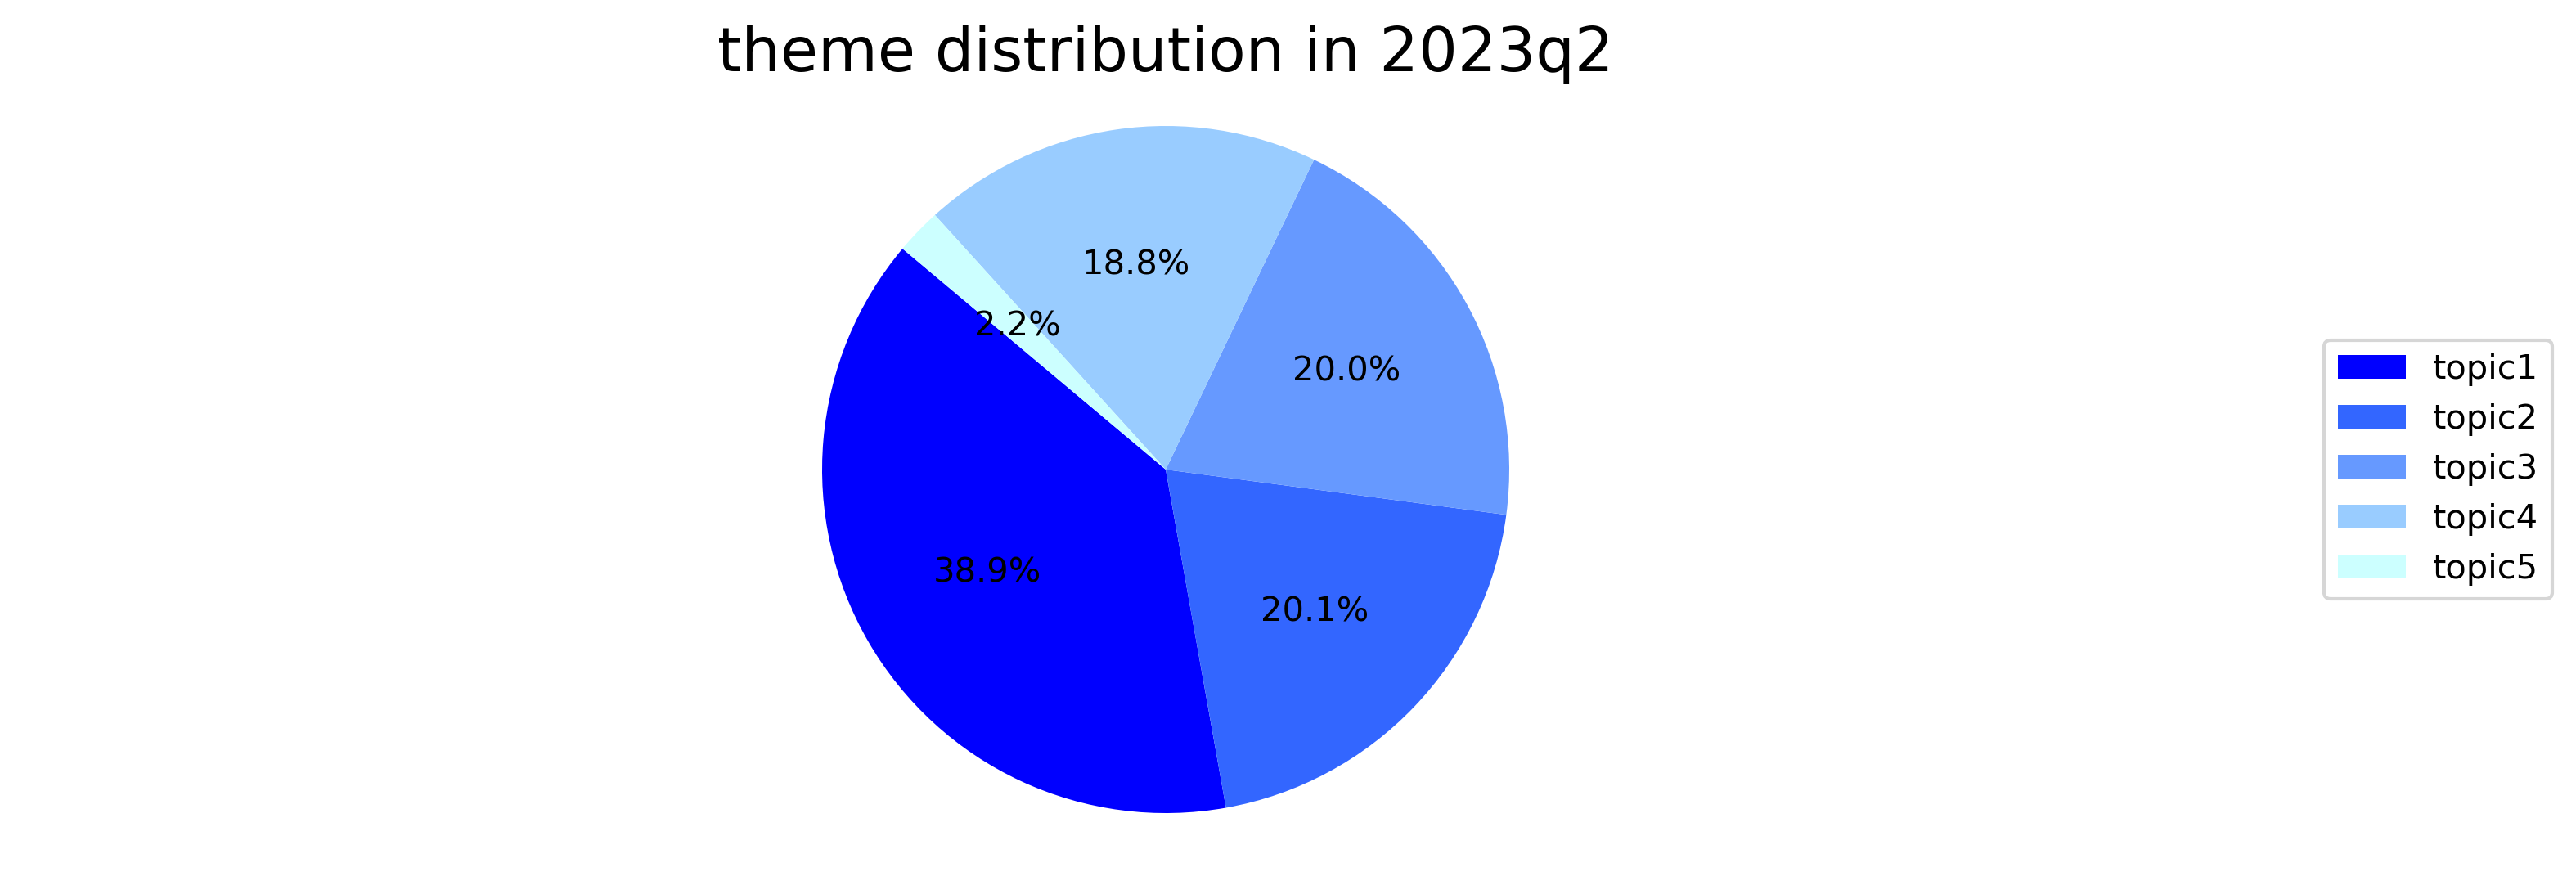

<Figure size 1920x1440 with 0 Axes>

In [47]:
import matplotlib.pyplot as plt
blue_colors = ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#CCFFFF']
def draw_pie_plot(time1, time2, title):
    data['date'] = pd.to_datetime(data['date'])
    data_short = data[(data['date'] > time1) & (data['date'] < time2)]
    # 明确指定对 'count' 列进行求和
    data_short = data_short.groupby(['topic'])['count'].sum().reset_index()
    data_short = data_short.sort_values(by='count', ascending=False)
    data_short = data_short.reset_index(drop=True)
    plt.rcParams['figure.dpi'] = 300
    plt.figure(figsize=(12, 4))
    # 绘制饼图
    wedges, texts, autotexts = plt.pie(
        data_short['count'],
        autopct='%1.1f%%',
        startangle=140,
        colors=blue_colors,
        radius=0.8
    )
    plt.axis('equal')
    plt.title(f"{title}", fontsize=18)
    plt.legend(wedges, data_short['topic'], loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.savefig(f"{title}.png", dpi=300, bbox_inches='tight')

draw_pie_plot("2023-04-01","2023-07-01","theme distribution in 2023q2")

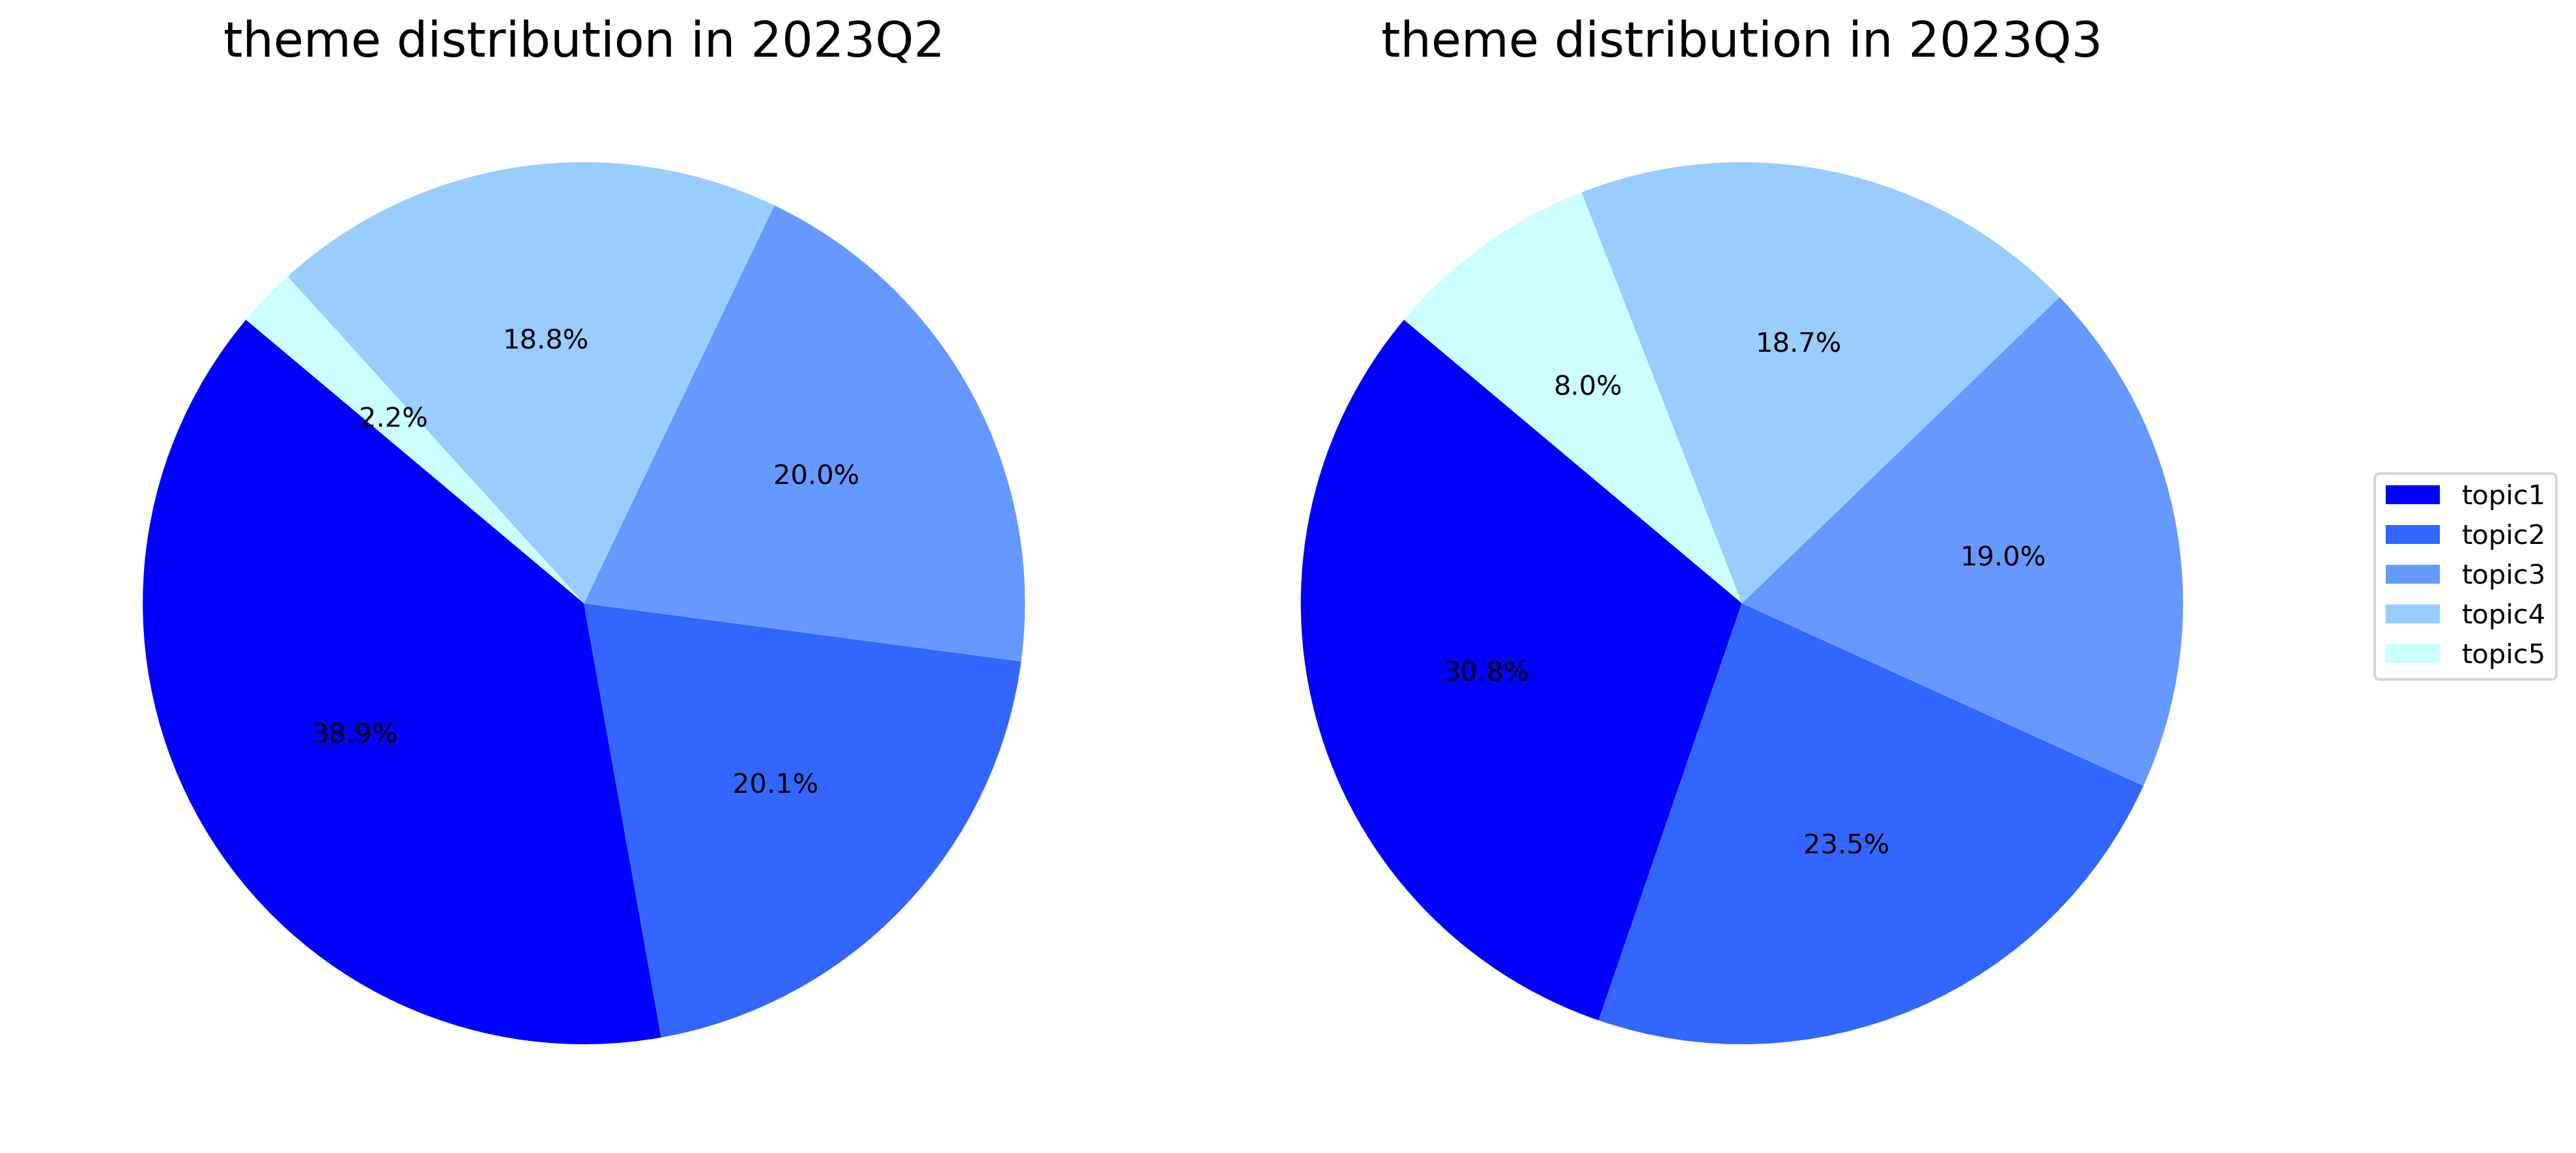

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

blue_colors = ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#CCFFFF']

def draw_double_pie_plots(time1_left, time2_left, title_left, time1_right, time2_right, title_right):
    data['date'] = pd.to_datetime(data['date'])

    # 筛选左边饼图的数据
    data_left = data[(data['date'] > time1_left) & (data['date'] < time2_left)]
    data_left = data_left.groupby(['topic'])['count'].sum().reset_index()
    data_left = data_left.sort_values(by='count', ascending=False)
    data_left = data_left.reset_index(drop=True)

    # 筛选右边饼图的数据
    data_right = data[(data['date'] > time1_right) & (data['date'] < time2_right)]
    data_right = data_right.groupby(['topic'])['count'].sum().reset_index()
    data_right = data_right.sort_values(by='count', ascending=False)
    data_right = data_right.reset_index(drop=True)

    plt.rcParams['figure.dpi'] = 300
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # 绘制左边的饼图
    wedges1, texts1, autotexts1 = ax1.pie(
        data_left['count'],
        autopct='%1.1f%%',
        startangle=140,
        colors=blue_colors,
        radius=0.8
    )
    ax1.axis('equal')
    ax1.set_title(title_left, fontsize=18)

    # 绘制右边的饼图
    wedges2, texts2, autotexts2 = ax2.pie(
        data_right['count'],
        autopct='%1.1f%%',
        startangle=140,
        colors=blue_colors,
        radius=0.8
    )
    ax2.axis('equal')
    ax2.set_title(title_right, fontsize=18)

    # 只添加一个图例
    fig.legend(wedges1, data_left['topic'], loc="center right", bbox_to_anchor=(1.1, 0.5))

    plt.tight_layout()
    plt.savefig("custom_theme_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

draw_double_pie_plots("2023-04-01", "2023-07-01", "theme distribution in 2023Q2",
                      "2023-07-01", "2023-10-01", "theme distribution in 2023Q3")
    